In [41]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

##### Loading and Cleaning Data from Rates Excel Data

In [42]:
# Dicts to identify which countries go with which tickers (all are 10-year Govt yields)
country_to_ticker = {}
country_to_ticker['US'] = 'USGG10YR'
country_to_ticker['Germany'] = 'GDBR10'
country_to_ticker['UK'] = 'GUKG10'
country_to_ticker['France'] = 'GFRN10'
country_to_ticker['Australia'] = 'GACGB10'
country_to_ticker['Canada'] = 'GCAN10YR'
country_to_ticker['New Zealand'] = 'GNZGB10'
country_to_ticker['Japan'] = 'JGBS10'
country_to_ticker['Switzerland'] = 'GSWISS10'
country_to_ticker['Norway'] = 'GNOR10YR'
country_to_ticker['Italy'] = 'GBTPGR10'

ticker_to_country = {}
for country, ticker in country_to_ticker.items():
    ticker_to_country[ticker] = country

# Assuming you have an Excel file named 'data.xlsx'
excel_file = pd.ExcelFile('G10_RV.xlsx')

# Get the first 10 sheet names
sheet_names = excel_file.sheet_names[:11]

# Combining rates_prices into single df
for i, country_sheet in enumerate(sheet_names):
    # print(i)
    # print(country_sheet)
    new_df = pd.read_excel('G10_RV.xlsx', sheet_name=country_sheet)[['Date', 'Last Price']]
    new_df.columns = ['Date', country_sheet]
    if i == 0:  # Start of the df
        df = new_df
    else:  # Merge to existing df
        df = df.merge(new_df, on='Date', how='outer')

# Filling in missing days with previous observations, defining which columns are rates we want
df = df.set_index('Date')
df = df.resample('D').asfreq()
df = df.ffill()
df = df[::-1].dropna()
rates_tickers = df.columns

df.head()

0
1
2
3
4
5
6
7
8
9
10


,USGG10YR,GDBR10,GUKG10,GFRN10,GACGB10,GCAN10YR,GNZGB10,JGBS10,GSWISS10,GNOR10YR,GBTPGR10
Date,,,,,,,,,,,
2024-03-29,4.2003,2.298,3.933,2.809,3.962,3.468,4.540,0.750,0.687,3.572,3.681
2024-03-28,4.2003,2.298,3.933,2.809,3.962,3.468,4.540,0.730,0.687,3.572,3.681
2024-03-27,4.1903,2.292,3.932,2.789,4.000,3.440,4.567,0.738,0.689,3.572,3.613
2024-03-26,4.2316,2.350,3.971,2.835,4.025,3.498,4.565,0.757,0.723,3.606,3.653
2024-03-25,4.2454,2.372,3.988,2.850,4.006,3.489,4.502,0.752,0.680,3.599,3.694


### Simple Linear Model
##### Choose one of the rates as a target, and use the others as predictors. We choose a given t value, and then calculate continuous changes in all rates for that t value. Then we regress changes in target against changes in predictors

In [55]:
def simple(t):
    # print(rates_tickers)
    rates_prices = df[rates_tickers].copy()
    # print(rates_prices)
    
    # Calculating our changes
    for ticker in rates_prices:
        # This line calculates the difference between the current value and the value t periods ahead for each ticker, and stores these differences in a new column named {ticker}_
        rates_prices[f'{ticker}_change_over_t'] = rates_prices[ticker].diff(-t)

    # This line removes any rows from data that contain missing values
    rates_prices = rates_prices.dropna()

    # This line creates a new DataFrame changes that only contains the columns in data that end with '_change_over_t' (the ones that contain the differences calculated earlier)
    changes = rates_prices[[x for x in rates_prices if x.endswith('_change_over_t')]]
    # print(changes)

    # This line splits the changes DataFrame into a training set, which contains all rows with a date index before '2023-1-1'
    changes_training = changes[changes.index < '2023-1-1']

    # This line creates the testing set, which contains all rows with a date index on or after '2023-1-1'
    changes_testing = changes[changes.index >= '2023-1-1']

    result = pd.DataFrame()

    # This line creates a new column 'Predictor' in the result DataFrame, which contains the tickers and some additional strings
    result['Predictor'] = [ticker_to_country[x] for x in rates_tickers] + ['Training r2', 'Testing r2']

    # Building model and storing results for each rate as the target, making df to see results
    for i, target_country in enumerate(changes.columns):
        
        # Stores all the training data in training X, not the current target country, for the X axis
        training_X = changes_training[[x for x in changes_training if x != target_country]]
        
        # Now store the training data of the target country for the Y axis
        training_y = changes_training[target_country]

        # Stores all the testing data in testing X, not the current target country, for the X axis
        testing_X = changes_testing[[x for x in changes_testing if x != target_country]]
        
        # Now store the training data of the target country for the Y axis
        testing_y = changes_testing[target_country]

        # Fit to model
        model = LinearRegression()
        model.fit(training_X, training_y)

        # Prediction over the training dataset
        training_prediction = model.predict(training_X)
        training_r2 = r2_score(training_y, training_prediction)

        # Prediction over the testing dataset
        testing_prediction = model.predict(testing_X)
        testing_r2 = r2_score(testing_y, testing_prediction)

        # Rounding our coefficients 
        coefficients = [round(x, 3) for x in model.coef_]
        # NO Value for prediction against self
        coefficients.insert(i, None)

        # Insert r2 scores
        coefficients.insert(len(coefficients), round(training_r2, 2))
        coefficients.insert(len(coefficients), round(testing_r2, 2))
        
        result[f'y: {ticker_to_country[target_country[:-14]]}'] = coefficients
    result['ABS Mean'] = [result.iloc[i, 1:].dropna().abs().mean() for i in range(11)] + ['', '']
    
    return result

simple(10)

,Predictor,y: US,y: Germany,y: UK,y: France,y: Australia,y: Canada,y: New Zealand,y: Japan,y: Switzerland,y: Norway,y: Italy,ABS Mean
0,US,NaN,0.065,0.279,-0.030,0.090,0.587,-0.046,0.009,-0.111,0.154,0.044,0.1415
1,Germany,0.391,NaN,0.563,0.742,-0.048,0.311,0.173,-0.034,0.654,0.386,-1.579,0.4881
2,UK,0.122,0.041,NaN,0.013,-0.036,-0.066,-0.014,-0.016,0.049,0.031,0.064,0.0452
3,France,-0.196,0.816,0.201,NaN,0.067,0.067,0.025,0.068,0.211,-0.298,2.742,0.4691
4,Australia,0.057,-0.005,-0.052,0.006,NaN,0.108,0.618,0.091,0.041,0.116,0.070,0.1164
5,Canada,0.603,0.053,-0.155,0.010,0.176,NaN,0.114,-0.021,-0.095,0.208,-0.088,0.1523
6,New Zealand,-0.020,0.012,-0.013,0.002,0.415,0.047,NaN,-0.020,0.011,0.036,0.013,0.0589
7,Japan,0.058,-0.036,-0.241,0.065,0.914,-0.129,-0.302,NaN,0.297,0.134,-0.036,0.2212
8,Switzerland,-0.152,0.149,0.154,0.044,0.090,-0.127,0.035,0.064,NaN,0.220,-0.182,0.1217
9,Norway,0.089,0.037,0.041,-0.026,0.106,0.116,0.049,0.012,0.092,NaN,-0.039,0.0607


### Multi-t model. More complex
##### In this model, instead of just using changes in predictors over time span t to predict changes in target over time span t, we also use changes over other t values for the predictor and the target itself as predictors. This helps the model pick up on some momentum factors (as much as a linear regression can). Best model would likely be a neural network where some nodes can really pick up on momentum

In [68]:
t_values = [1,5,10,25,50,100]

def multi(target, t):
    target_t = f'{target}_change_over_{t}'
    rates_prices = df[rates_tickers].copy()
    # Adding changes for each t value we specified for every ticker
    for ticker in rates_tickers:
        for x in t_values:
            rates_prices[f'{ticker}_change_over_{x}'] = rates_prices[ticker].diff(-x)

    # Training model and storing predictions and performance. Too many predictors to make clean df
    rates_prices = rates_prices.dropna()
    data_training = rates_prices[rates_prices.index < '2023-1-1'].copy()
    data_testing = rates_prices[rates_prices.index >= '2023-1-1'].copy()
    training_X = data_training[[x for x in data_training if '_' in x and x != target_t]]
    training_y = data_training[target_t]
    testing_X = data_testing[[x for x in data_testing if '_' in x and x != target_t]]
    testing_y = data_testing[target_t]
    model = LinearRegression()
    model.fit(training_X, training_y)
    testing_prediction = model.predict(testing_X)
    r2 = round(r2_score(testing_y, testing_prediction),2)
    data_testing['c_prediction'] = testing_prediction
    prediction = data_testing[[target, target_t, 'c_prediction']].copy()
    prediction['prediction'] = prediction[target].shift(-t) + prediction['c_prediction']
    prediction = prediction[[target, 'prediction']].dropna()
    return prediction, r2

### Evaluating how prediction performance for using given t value as target compares between the models

In [69]:
def t_eval(t):
    r2s = pd.DataFrame()
    r2s['Target'] = list(country_to_ticker.keys())
    r2s['r2: simple'] = r2s['Target'].apply(lambda x: simple(t)[f'y: {x}'][12])
    r2s['r2: multi'] = r2s['Target'].apply(lambda x: multi(country_to_ticker[x], t)[1])
    r2s = r2s.set_index('Target')
    return r2s

t_eval(10)

,r2: simple,r2: multi
Target,,
US,0.86,0.89
Germany,0.98,0.98
UK,0.69,0.81
France,0.99,0.98
Australia,0.74,0.79
Canada,0.82,0.87
New Zealand,0.71,0.79
Japan,0.20,0.54
Switzerland,0.57,0.50


##### We now have predictions for where we think the rate "should" be. Now, we trade if the prediction is over or below the observed price by a certain threshold that we set. Lower threshold leads to more trades and vice versa.

In [63]:
def trader(ticker, t, threshold):
    data = multi(ticker, t)[0]
    data['signal'] = 0
    data.loc[data[ticker] > data['prediction'] + threshold, 'signal'] = -1
    data.loc[data[ticker] < data['prediction'] - threshold, 'signal'] = 1
    data['return'] = data[ticker].diff(-1) * data['signal']
    data = data[::-1]
    data['PnL'] = data['return'].cumsum()
    return data['PnL']

##### Very important to fix this. Right now just went in and manually inputed values that worked best for each rate. This is obviously data mining and need to come up with some function to predict what the best values would be, maybe using the r2s. Higher r2s may mean we can make a model that trades more and vice versa

In [64]:
best_values = {}
best_values['US'] = (100, .01)
best_values['Germany'] = (50, .01)
best_values['UK'] = (50, .01)
best_values['France'] = (10, .01)
best_values['Australia'] = (10, .05)
best_values['Canada'] = (100, .01)
best_values['New Zealand'] = (100, .05)
best_values['Japan'] = (10, .01)
best_values['Switzerland'] = (50, .01)
best_values['Norway'] = (50, .01)
best_values['Italy'] = (100, .05)

##### Seeing how the strategy performs for each rate

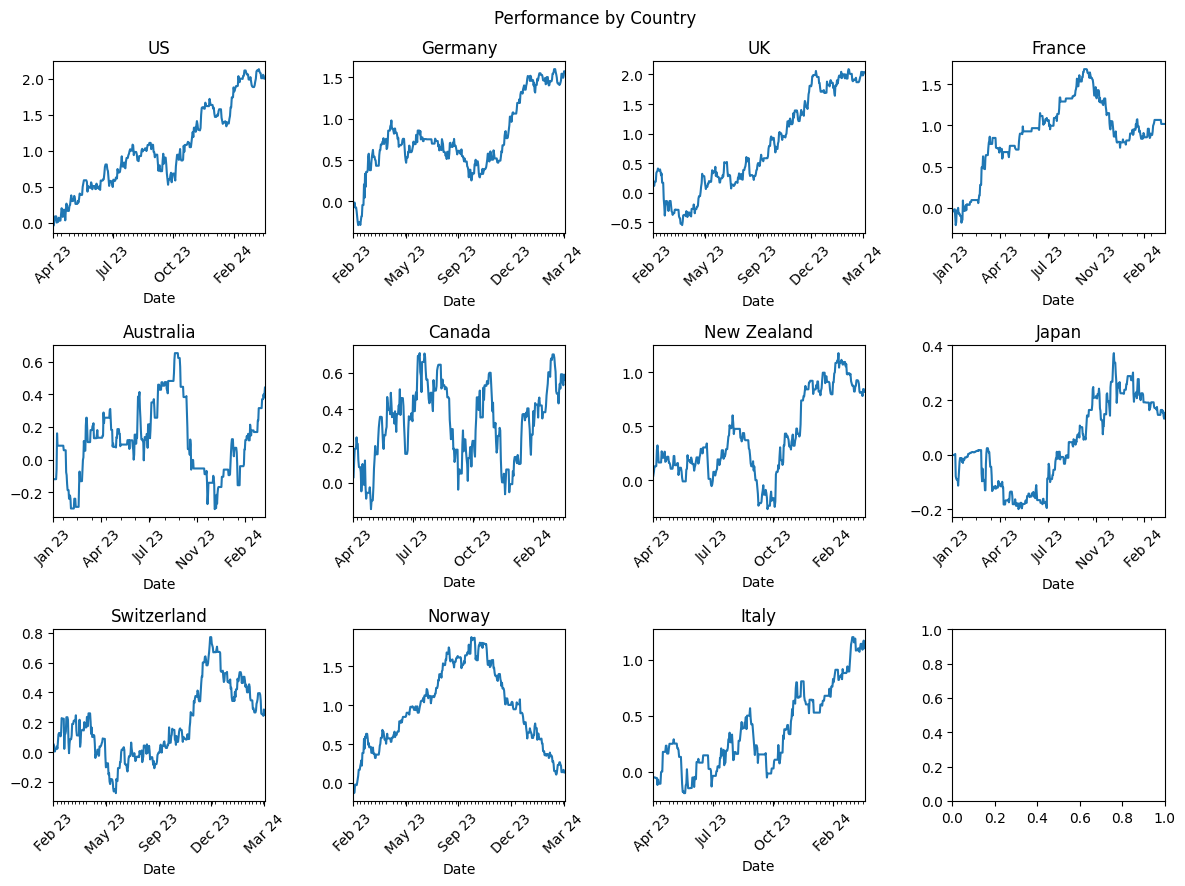

In [65]:
countries = list(codes.keys())
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
axs = axs.flatten()

for i, country in enumerate(countries):
    t, threshold = best_values[country]
    ax = axs[i]
    trade_data = trader(codes[country], t, threshold)
    trade_data.plot(ax=ax)
    ax.set_title(country)
    tick_positions = trade_data.index[::100]
    tick_labels = [d.strftime('%b %y') for d in tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Performance by Country')
plt.tight_layout()
plt.show()